In [ ]:
import pickle
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
import sys
sys.path.append(r"D:\Maths_Y4\Project\Bayesian-Neural-Network-Project\Rebuilding_Slang")
from torchutils.models import MLP as MultiSampleMLP



path = r"D:\Maths_Y4\Project\Bayesian-Neural-Network-Project\Rebuilding_Slang\results_L32_1000.pkl"

with open(path, 'rb') as f:
    results_dict = pickle.load(f)

In [3]:
## I believe this is an unstable method
param_means = results_dict['optimizer']['state']['mean']
prec_factor = results_dict['optimizer']['state']['prec_factor']
prec_diag = results_dict['optimizer']['state']['prec_diag']

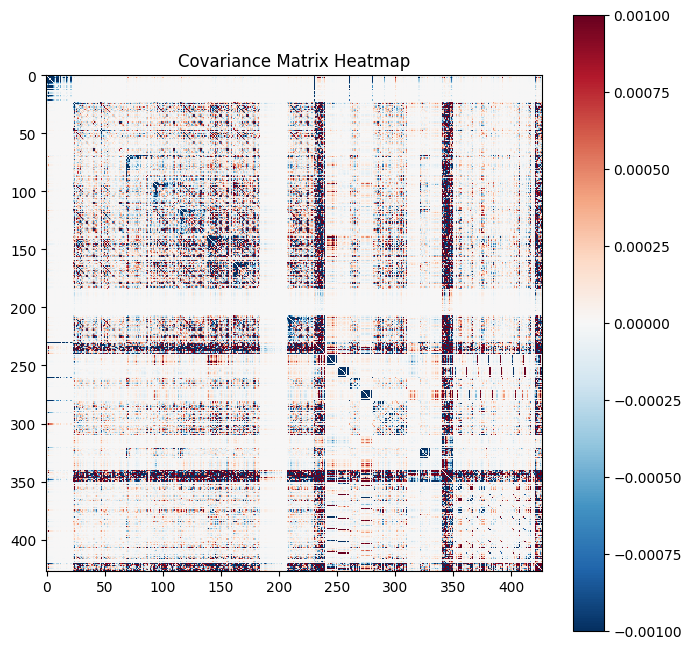

In [4]:
d_inv = torch.diag(1/prec_diag.squeeze()) # vector of diagonal inverse

Kinv = torch.eye(prec_factor.size(1)) + prec_factor.t() @ (d_inv @ prec_factor)
s1 = (d_inv @ prec_factor).t()
s2 = torch.linalg.solve(Kinv, s1)
cov_matrix = ((d_inv) - (d_inv@prec_factor)@(s2))

cov_matrix.fill_diagonal_(0)

cov_matrix = cov_matrix.detach().cpu().numpy()
threshold = 0.001
clipped_cov_matrix = np.clip(cov_matrix, -threshold, threshold)

# cov_matrix[330:350,330:350] = np.zeros((20,20))
plt.figure(figsize=(8, 8)) 
plt.imshow((clipped_cov_matrix), cmap='RdBu_r', interpolation='nearest',vmin=np.min(clipped_cov_matrix), vmax=np.max(clipped_cov_matrix)) 
plt.colorbar() 
plt.title("Covariance Matrix Heatmap") 
plt.show()

In [5]:
import torch
import torch.nn.functional as F

def forward(params, x):
    # Step 1: Initialize layers
    offset = 0

    layer_0_weights = params[:23*10].reshape(10,23)
    layer_0_bias = params[23*10:23*10+10]

    offset += 23*10+10

    layer_1_weights = params[offset:offset + 10*10].reshape(10,10)
    layer_1_bias = params[offset + 10*10: offset + 10*10 + 10]
    offset += 10*10 + 10

    layer_2_weights = params[offset : offset + 10*7].reshape(7,10)
    layer_2_bias = params[offset +10*7: ]

    
    x = F.linear(x, layer_0_weights, layer_0_bias)
    x = torch.relu(x)
    x = F.linear(x, layer_1_weights, layer_1_bias)
    x = torch.relu(x)
    x = F.linear(x, layer_2_weights, layer_2_bias)
    x = torch.softmax(x, dim = 1)
    return x


In [6]:
from ucimlrepo import fetch_ucirepo 

# fetch dataset 
estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition = fetch_ucirepo(id=544) 
  
# data (as pandas dataframes) 
X = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.features 
y = estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.data.targets.copy() 
  
# metadata 
print(estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.metadata) 
  
# variable information 
print(estimation_of_obesity_levels_based_on_eating_habits_and_physical_condition.variables) 



{'uci_id': 544, 'name': 'Estimation of Obesity Levels Based On Eating Habits and Physical Condition ', 'repository_url': 'https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition', 'data_url': 'https://archive.ics.uci.edu/static/public/544/data.csv', 'abstract': 'This dataset include data for the estimation of obesity levels in individuals from the countries of Mexico, Peru and Colombia, based on their eating habits and physical condition. ', 'area': 'Health and Medicine', 'tasks': ['Classification', 'Regression', 'Clustering'], 'characteristics': ['Multivariate'], 'num_instances': 2111, 'num_features': 16, 'feature_types': ['Integer'], 'demographics': ['Gender', 'Age'], 'target_col': ['NObeyesdad'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2019, 'last_updated': 'Tue Sep 10 2024', 'dataset_doi': '10.24432/C5H31Z', 'creators': [], 'intro_paper': {'ID': 358, 'type': 

In [7]:
import pandas as pd
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [8]:
categorical_features = ['Gender', 'family_history_with_overweight', 'FAVC', 'CAEC', 'SMOKE', 'SCC','CALC','MTRANS']
# One-hot encode categorical features, dropping the first category
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)
X_encoded = X_encoded.astype({col: int for col in X_encoded.select_dtypes('bool').columns})

# Convert X_encoded to a PyTorch tensor
X_tensor = torch.tensor(X_encoded.values, dtype=torch.float32)
X_tensor.shape

torch.Size([2111, 23])

In [9]:
y['NObeyesdad'] = y['NObeyesdad'].astype('category').cat.codes

# Convert to tensor
y_tensor = torch.tensor(y['NObeyesdad'].to_numpy(), dtype=torch.long)

In [10]:
x_tr, x_te, y_tr, y_te = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)

In [13]:
mean = x_tr.mean(dim=0, keepdim=True)
std = x_tr.std(dim=0, keepdim=True)

x_tr_norm = (x_tr - mean) / std
x_te_norm = (x_te - mean) / std

In [14]:
def factCore(V, reduce_flag=False):
    r"""Computes :math:`K` such that :math:`I_n + VKV^\top`
    is a square-root for :math:`I_n + VV^\top`

    Arguments:
        V (Tensor): a low-rank matrix of size [n x k]
    """
        
    I_k = torch.eye(V.shape[1], dtype=V.dtype, device=V.device)
    # L = torch.potrf(V.t() @ V, upper=False)
    # M = torch.potrf(I_k + L.t() @ L, upper=False)
    L = torch.linalg.cholesky(V.t() @ V, upper=False)
    M = torch.linalg.cholesky(I_k + L.t() @ L, upper=False)
    Linv = torch.inverse(L)
    K = Linv.t() @ (M - I_k) @ Linv
    return K, V


In [15]:
def invFactMult(U, d, x):
    r"""Computes :math:`Cx` where :math:`CC^\top = (UU^\top + diag(d))^{-1}`

    Arguments:
        U (Tensor): a low-rank matrix of size [n x k]
        d (Tensor): a vector ([n x 1] Tensor) representing the diagonal
        x (Tensor): size [n x d]
    """
    d_sqrt = torch.sqrt(d)
    V = U/d_sqrt

    K, V = factCore(V)

    dirInv = torch.inverse(torch.inverse(K.t()) + V.t() @ V) @ (V.t() @ x)
    return (x - V @ dirInv)/d_sqrt

In [16]:
def rsample(mean, prec_factor, prec_diag, n_samples=1):
    eps = torch.randn((mean.shape[0], n_samples))
    
    return mean.view(-1,1) + invFactMult(prec_factor, prec_diag, eps)

In [17]:
def forward(params, x):
    # Step 1: Initialize layers
    offset = 0

    layer_0_weights = params[:23*10].reshape(10,23)
    layer_0_bias = params[23*10:23*10+10]

    offset += 23*10+10

    layer_1_weights = params[offset:offset + 10*10].reshape(10,10)
    layer_1_bias = params[offset + 10*10: offset + 10*10 + 10]
    offset += 10*10 + 10

    layer_2_weights = params[offset : offset + 10*7].reshape(7,10)
    layer_2_bias = params[offset +10*7: ]

    
    x = F.linear(x, layer_0_weights, layer_0_bias)
    x = torch.relu(x)
    x = F.linear(x, layer_1_weights, layer_1_bias)
    x = torch.relu(x)
    x = F.linear(x, layer_2_weights, layer_2_bias)
    x = torch.softmax(x, dim = 1)
    return x


In [18]:
samples = rsample(param_means, prec_factor, prec_diag, 100)

In [19]:
outputs = torch.stack([forward(params, x_te_norm) for params in samples.T])  # Apply `forward` to each sample

In [20]:
mean_preds = outputs.mean(0)
indices = mean_preds.argmax(dim=1)
indices[:10]

tensor([3, 3, 1, 3, 3, 3, 3, 3, 3, 3])

In [ ]:
import torch.nn.functional as F

model = MultiSampleMLP(input_size=23,
                           hidden_sizes=[10,10],
                           output_size=7,
                           act_func=F.relu)

MLP(
  (hidden_layers): ModuleList(
    (0): LinearWithSampling(in_features=23, out_features=10, bias=True)
    (1): LinearWithSampling(in_features=10, out_features=10, bias=True)
  )
  (output_layer): LinearWithSampling(in_features=10, out_features=7, bias=True)
)

In [38]:
def rsample(n_samples=1):
    eps = torch.randn((427, n_samples), dtype=torch.float32)
    return param_means.view(-1,1) + invFactMult(prec_factor, prec_diag, eps)
    

In [39]:
def predict_fn(x, mc_samples):
    noise = rsample(mc_samples).t()
   
    preds = model(x, noise, False)
    return preds

In [40]:
mean_preds = predict_fn(x_te, 10).mean(0)

In [41]:
indices = mean_preds.argmax(dim=1)
indices[:10]

tensor([3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [34]:
y_te[:10]

tensor([0, 4, 0, 0, 1, 0, 3, 5, 2, 0])

In [35]:
mean_preds

tensor([[3.2404e-02, 8.5539e-01, 2.7026e-07,  ..., 1.0387e-02, 5.6332e-02,
         3.0794e-02],
        [1.3258e-01, 6.9750e-01, 6.3591e-09,  ..., 2.9224e-02, 1.0006e-01,
         3.0632e-02],
        [3.9022e-02, 8.3677e-01, 1.2764e-09,  ..., 1.0609e-02, 7.1005e-02,
         3.1712e-02],
        ...,
        [5.0934e-02, 7.9796e-01, 6.3019e-09,  ..., 2.0610e-02, 7.4437e-02,
         4.2001e-02],
        [1.3130e-02, 7.8885e-01, 1.0188e-05,  ..., 1.9320e-02, 8.4527e-02,
         7.3951e-02],
        [1.3696e-01, 7.1897e-01, 1.4039e-08,  ..., 2.0226e-02, 8.7611e-02,
         2.6228e-02]], grad_fn=<MeanBackward1>)

In [43]:
samples = rsample(param_means, prec_factor, prec_diag, 10000)

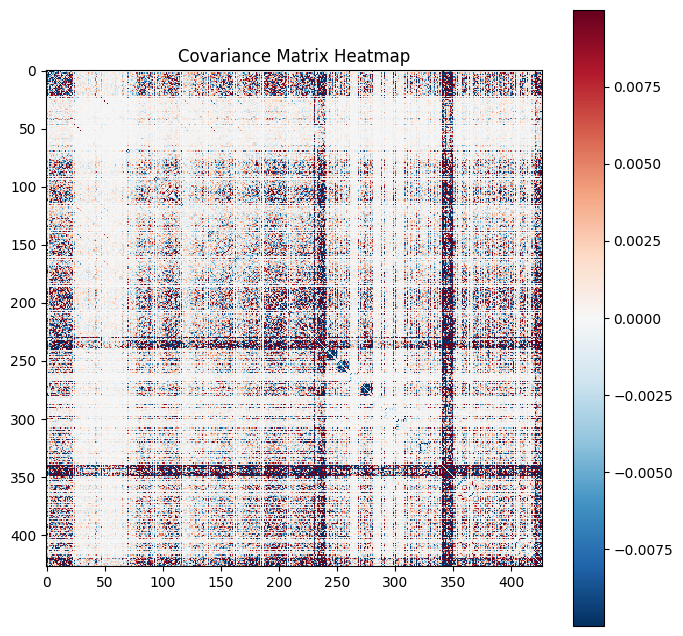

In [53]:
cov_matrix = torch.cov(samples)
cov_matrix.fill_diagonal_(0)

cov_matrix = cov_matrix.detach().numpy()

threshold = 0.01
clipped_cov_matrix = np.clip(cov_matrix, -threshold, threshold)
plt.figure(figsize=(8, 8)) 
# plt.imshow((cov_matrix), cmap='RdBu_r', interpolation='nearest',vmin=np.min(cov_matrix), vmax=np.max(cov_matrix)) 
plt.imshow((clipped_cov_matrix), cmap='RdBu_r', interpolation='nearest',vmin=np.min(clipped_cov_matrix), vmax=np.max(clipped_cov_matrix)) 

plt.colorbar() 
plt.title("Covariance Matrix Heatmap") 
plt.show()

In [39]:
samples.shape

torch.Size([427, 100])